In [3]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random

In [4]:
model = interpretability.load_model(
    "../scripts/models/tiny model prob all games-20230811-173207"
)

In [5]:
seq_fwd = [10, 0, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
pos_emb = model.pos_embed(torch.zeros(1, 10), 0)
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
preds_mlp_pos = torch.softmax(logits_mlp_pos, axis=-1)
logits_mlp_pos.shape, preds_mlp_pos.shape

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]))

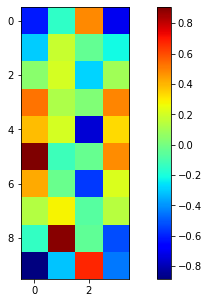

In [69]:
plt.imshow(pos_emb[0].detach().cpu().numpy(), cmap="jet")
plt.colorbar()

In [18]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [9]:
test = neuron_posembed_activations(pos_emb)
test.shape

torch.Size([1, 10, 16])

In [10]:
last_token_acts = test[0][-1].detach().cpu().numpy()

In [11]:
print(np.count_nonzero(last_token_acts))
print(np.count_nonzero(last_token_acts) / last_token_acts.size)

10
0.625


In [12]:
last_token_2d = last_token_acts[np.newaxis, :]
last_token_2d.shape

(1, 16)

Text(0.5, 0, 'Neuron')

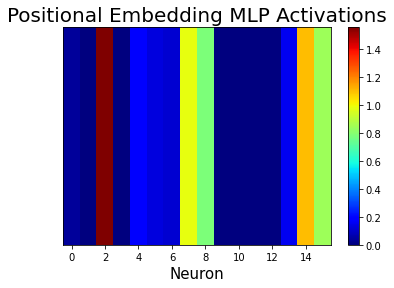

In [13]:
#plot last token acts imshow
plt.imshow(last_token_2d, aspect="auto", cmap="jet")
plt.colorbar()
#figsize params
plt.rcParams['figure.figsize'] = 10, 5
#title
plt.title("Positional Embedding MLP Activations", fontsize=20)
plt.gcf().set_facecolor("white")
#y tick
plt.yticks([1])
#x label
plt.xlabel("Neuron", fontsize=15)

In [14]:
games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')
games.head()

/tmp/ipykernel_15490/1995611786.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [15]:
nine_move_games = [[10]+eval(move) for move in games[games['steps till end state'] == 9]['moves played']]

In [56]:
activations = []
for _ in range(50):
    data = torch.tensor(random.choice(nine_move_games))
    activations.append(neuron_activations(data)[0][-1])

In [57]:
stacked_acts = torch.stack(activations)
stacked_acts = stacked_acts.detach().cpu().numpy()
stacked_acts = stacked_acts.T

<Figure size 720x360 with 0 Axes>

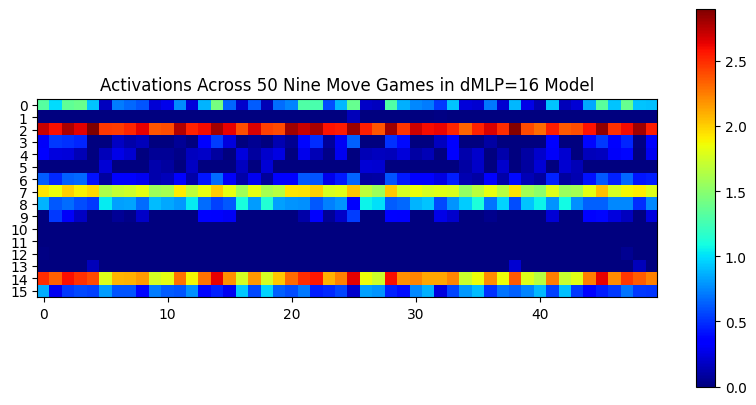

In [64]:
plt.figure(figsize=(10, 5))
#dpi
plt.figure(dpi=100)
plt.imshow(stacked_acts, cmap="jet")
#colorbar
plt.colorbar()
#xticks
plt.yticks(np.arange(0, 16, 1));
#title
plt.title("Activations Across 50 Nine Move Games in dMLP=16 Model", fontsize=12)
plt.gcf().set_facecolor("white")